# Train Toy Model of Superposition

In [8]:
# Load in  outputs/toy_models/correlated_input.pt with torch.load
import torch
model = torch.load('../outputs/toy_models/correlated_input.pt')



ModuleNotFoundError: No module named 'toy_models'

In [15]:
    import numpy as np
    import einops
    num_datapoints = 100
    sparsity = 0.1
    correlation_set_size = 3
    num_features = 12
    # Initialize feature vectors with random values
    feature_vectors: np.ndarray = np.random.rand(num_datapoints, num_features)
    # Apply sparsity to the feature vectors
    
    
    sparsity_mask = einops.repeat((np.random.rand(num_datapoints, int(num_features/correlation_set_size)) < sparsity), 'sample feature -> sample (feature s)', s=correlation_set_size)

In [16]:
sparsity_mask[2]


array([False, False, False,  True,  True,  True, False, False, False,
       False, False, False])

In [18]:
binary_numbers_str: np.ndarray = np.array([np.binary_repr(n, width=num_features) for n in binary_numbers])

torch.tensor([[1 if digit=='1' else -1 for digit in b] for b in binary_numbers_str])

NameError: name 'torch' is not defined

tensor(0.0747, grad_fn=<LinalgVectorNormBackward0>)


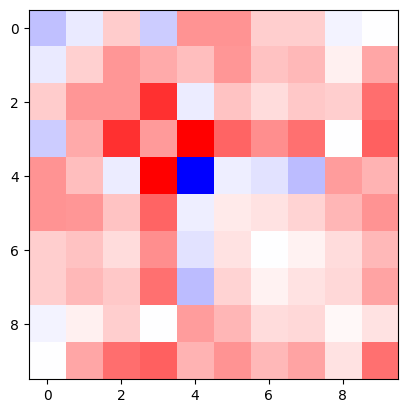

In [143]:
# Show W_out @ W_in @ H @ W_in.T @ W_out.T - H with imshow
from matplotlib import pyplot as plt
diff = W_out @ W_in @ H @ W_in.T @ W_out.T - H
plt.imshow(diff.detach().numpy(), cmap='bwr')


print(diff.norm())

In [126]:
from torch import Tensor
import torch 

# Make me a random symmetric matrix
H = torch.rand(10, 5)
H = H @ H.transpose(0,1)

# ... existing code ...

# Make W_in and W_out require gradients from the start
W_in = torch.nn.Parameter(torch.randn(10, 10))
W_out = torch.nn.Parameter(torch.randn(10, 10))

# Normalize W_in (but keep it as a parameter)
with torch.no_grad():
    W_in.data = W_in.data / torch.norm(W_in.data, dim=0)

# Define the optimizer with the parameters
optimizer = torch.optim.Adam([W_in, W_out], lr=0.001)

def loss_fn(W_in, W_out, H, v):
    return torch.norm(W_out @ W_in @ H @ v - (H @ v))

# Training loop
for i in range(100000):
    optimizer.zero_grad()
    # Sample v from rademacher distribution
    

    #v = torch.randn(H.shape[0], 1)
    #v = torch.where(v > 0, 1.0, -1.0).detach()
    
    v = torch.eye(H.shape[0])
    loss = loss_fn(W_in, W_out, H, v)
    loss.backward()
    optimizer.step()
    
    # Renormalize W_in after each step
    W_in.data.div_(torch.norm(W_in.data, dim=0))
    
    if i % 10000 == 0:
        print(f"Iteration {i}, Loss: {loss.item():.4f}")
        diff = W_out @ W_in @ H @ W_in.T @ W_out.T - H
        print(diff.norm().item())
# ... existing code ...

Iteration 0, Loss: 23.2621
53.704673767089844


Iteration 10000, Loss: 0.0319
0.04160083085298538
Iteration 20000, Loss: 0.0394
0.047546640038490295


KeyboardInterrupt: 

In [122]:
# Get eigenvalues of H
eigenvalues = torch.linalg.eigvals(H)
print(eigenvalues)


tensor([ 1.4619e+01+0.j,  1.2205e+00+0.j,  7.4423e-01+0.j,  9.6596e-01+0.j,
         2.4430e-01+0.j, -2.0550e-07+0.j, -3.7852e-07+0.j, -7.4106e-08+0.j,
         8.6402e-08+0.j,  7.0814e-09+0.j])


tensor(0.0735, grad_fn=<LinalgVectorNormBackward0>)


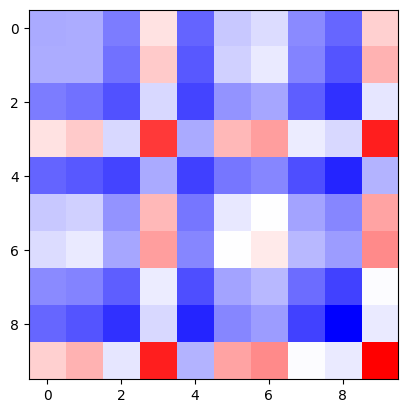

In [123]:
# Show W_out @ W_in @ H @ W_in.T @ W_out.T - H with imshow
from matplotlib import pyplot as plt
diff = W_out @ W_in @ H @ W_in.T @ W_out.T - H
plt.imshow(diff.detach().numpy(), cmap='bwr')


print(diff.norm())

In [12]:
from toy_models.trainer import Trainer as ModelTrainer
from toy_models.tms import Autoencoder, GenerateTMSData




In [13]:
from eigenmodel.eigenmodel import EigenModel


In [1]:
import torch
import torch.func as tf

def batched_hessian_vector_product(model, loss_fn, inputs, targets, vectors):
    """
    Computes Hessian-vector products (HVP) for a batch efficiently without explicit loops.

    Args:
        model: PyTorch model
        loss_fn: Loss function
        inputs: Batch of input samples (tensor of shape [batch_size, input_dim])
        targets: Batch of targets (tensor of shape [batch_size, output_dim])
        vectors: Batch of vectors (tensor of shape [batch_size, num_params])

    Returns:
        A tensor of shape [batch_size, num_params] containing the Hessian-vector products.
    """
    # Define a function that takes model parameters and computes loss per sample
    def single_loss(params, x, y):
        pred = tf.functional_call(model, params, (x,))
        return loss_fn(pred, y)

    # Get the model parameters as a PyTree
    params = {k: v for k, v in model.named_parameters()}
    
    # Compute per-sample gradients (batched automatically)
    grad_fn = tf.jacrev(single_loss)  # First-order gradient function
    grads = torch.vmap(grad_fn, in_dims=(None, 0, 0))(params, inputs, targets)

    # Flatten gradients into a single vector per sample
    def flatten(pytree):
        return torch.cat([p.flatten(start_dim=1) for p in pytree.values()], dim=1)
    
    grad_vectors = flatten(grads)  # Shape: (batch_size, num_params)

    # Compute Hessian-vector product efficiently
    def hvp_fn(v):
        return torch.vmap(lambda g: torch.autograd.grad(g, params.values(), g=v, retain_graph=True))(grad_vectors)

    hvp = hvp_fn(vectors)

    return hvp

# Example Usage
batch_size = 4
input_dim = 10
output_dim = 1

model = torch.nn.Linear(input_dim, output_dim)
loss_fn = torch.nn.MSELoss()

# Dummy Data
inputs = torch.randn(batch_size, input_dim)
targets = torch.randn(batch_size, output_dim)

# Get the number of model parameters
num_params = sum(p.numel() for p in model.parameters())

# Create random vectors for each sample
vectors = torch.randn(batch_size, num_params)

# Compute Hessian-vector products
hvps = batched_hessian_vector_product(model, loss_fn, inputs, targets, vectors)

# Print results
print("Hessian-vector products shape:", hvps.shape)  # Should be [batch_size, num_params]


TypeError: grad() got an unexpected keyword argument 'g'

In [4]:
sum([torch.tensor([1,2,3]) for _ in [1,2,3]])

tensor([3, 6, 9])

In [3]:
[2 for _ in [1,2,3]]

[2, 2, 2]